# Tree Species Classification - Final Evaluation
## Complete Project Deliverable

This notebook addresses **all project requirements**:

### 1. Model Development (Primary Comparison)
- **ResNet50** (larger model) - 25.6M parameters - Transfer Learning
- **ResNet18** (smaller model) - 11.7M parameters - Transfer Learning

### Supporting Comparison Model
- **TreeNet** (custom CNN) - ~2.5M parameters - Trained from scratch on this dataset

### 2. Model Testing and Evaluation
- Accuracy, Precision, Recall, F1-score for each model
- Confusion matrices for each model
- N-best (Top-K) classification analysis
- Find value of n where n-best results separate model performance

### 3. Error Analysis & Data Preprocessing Recommendations
- Study errors made by models
- Recommendations for data preprocessing improvements

### Key Comparison:
**ResNet50 vs ResNet18** (two different sized ResNet architectures)

### Supporting Analysis:
**TreeNet** (custom CNN trained from scratch) - demonstrates transfer learning advantage

---
## 1. Setup & Imports

In [1]:
import os
import random
import warnings
import platform
import multiprocessing
import json
from pathlib import Path
from collections import Counter
from copy import deepcopy

try:
    multiprocessing.set_start_method('spawn', force=True)
except RuntimeError:
    pass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    precision_recall_fscore_support,
    accuracy_score
)
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 8)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 4090


In [2]:
# Setup
def setup(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = setup(seed=42)
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Configuration
DATA_ROOT = Path("data/classification_tree")
IMG_SIZE = 224

if platform.system() == 'Linux':
    NUM_WORKERS = 16
    PERSISTENT_WORKERS = True
    BATCH_SIZE = 128
else:
    NUM_WORKERS = 0
    PERSISTENT_WORKERS = False
    BATCH_SIZE = 64

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results', exist_ok=True)

print(f"Configuration: BATCH_SIZE={BATCH_SIZE}, NUM_WORKERS={NUM_WORKERS}")

Configuration: BATCH_SIZE=128, NUM_WORKERS=16


---
## 2. Load Dataset

In [4]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Load datasets
train_dir = DATA_ROOT / "train"
val_dir = DATA_ROOT / "val"
test_dir = DATA_ROOT / "test"

train_dataset = datasets.ImageFolder(root=str(train_dir), transform=train_transforms)
val_dataset = datasets.ImageFolder(root=str(val_dir), transform=val_transforms)
test_dataset = datasets.ImageFolder(root=str(test_dir), transform=val_transforms)

classes = train_dataset.classes
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Training samples:   {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples:       {len(test_dataset):,}")

Number of classes: 23
Training samples:   3,850
Validation samples: 482
Test samples:       472


In [5]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS if NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS if NUM_WORKERS > 0 else False
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=False
)

# Class weights for imbalanced data
class_counts = Counter([label for _, label in train_dataset.samples])
total_samples = len(train_dataset)
class_weights = torch.tensor(
    [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)],
    dtype=torch.float32
).to(device)
class_weights = class_weights / class_weights.sum() * num_classes

print(f"DataLoaders created. Train batches: {len(train_loader)}")

DataLoaders created. Train batches: 31


---
## 3. Model Definitions

### 3.1 TreeNet - Custom CNN (Comparison Model - Trained from Scratch)

In [6]:
class ConvBlock(nn.Module):
    """Convolution + BatchNorm + ReLU block."""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)


class TreeNet(nn.Module):
    """
    Custom CNN for tree species classification.
    TRAINED FROM SCRATCH - No pretrained weights.
    
    Architecture: 5 stages of ConvBlocks with MaxPooling
    Channels: base -> base*2 -> base*4 -> base*8 -> base*16
    """
    def __init__(self, num_classes=23, dropout=0.5, base_channels=32):
        super().__init__()
        
        c = base_channels
        
        self.features = nn.Sequential(
            # Stage 1: 224 -> 112
            ConvBlock(3, c),
            ConvBlock(c, c),
            nn.MaxPool2d(2, 2),
            
            # Stage 2: 112 -> 56
            ConvBlock(c, c*2),
            ConvBlock(c*2, c*2),
            nn.MaxPool2d(2, 2),
            
            # Stage 3: 56 -> 28
            ConvBlock(c*2, c*4),
            ConvBlock(c*4, c*4),
            nn.MaxPool2d(2, 2),
            
            # Stage 4: 28 -> 14
            ConvBlock(c*4, c*8),
            ConvBlock(c*8, c*8),
            nn.MaxPool2d(2, 2),
            
            # Stage 5: 14 -> 7
            ConvBlock(c*8, c*16),
            ConvBlock(c*16, c*16),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(c*16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def create_treenet(num_classes=23, dropout=0.5, base_channels=32):
    """Create TreeNet model (trained from scratch)."""
    return TreeNet(num_classes=num_classes, dropout=dropout, base_channels=base_channels)

print("TreeNet (Custom CNN - Trained from Scratch) defined")

TreeNet (Custom CNN - Trained from Scratch) defined


### 3.2 ResNet Models (Transfer Learning)

In [7]:
def create_resnet(model_name='resnet50', num_classes=23, dropout=0.4, pretrained=True):
    """
    Create ResNet model with custom classifier head.
    Uses ImageNet pretrained weights for TRANSFER LEARNING.
    
    Supports: resnet18, resnet50
    """
    if model_name == 'resnet18':
        if pretrained:
            model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            model = models.resnet18(weights=None)
        num_features = 512
    elif model_name == 'resnet50':
        if pretrained:
            model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            model = models.resnet50(weights=None)
        num_features = 2048
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    # Custom classifier head
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.Linear(256, num_classes)
    )
    
    return model

print("ResNet models (Transfer Learning) defined")

ResNet models (Transfer Learning) defined


In [8]:
# Print model comparison
print("\n" + "="*70)
print("MODEL ARCHITECTURE COMPARISON")
print("="*70)
print(f"\n{'Model':<20} {'Parameters':>15} {'Training Method':<25}")
print("-"*60)

treenet_params = sum(p.numel() for p in create_treenet(num_classes).parameters())
resnet18_params = sum(p.numel() for p in create_resnet('resnet18', num_classes, pretrained=False).parameters())
resnet50_params = sum(p.numel() for p in create_resnet('resnet50', num_classes, pretrained=False).parameters())

print(f"{'TreeNet':<20} {treenet_params:>15,} {'From Scratch':<25}")
print(f"{'ResNet18':<20} {resnet18_params:>15,} {'Transfer Learning':<25}")
print(f"{'ResNet50':<20} {resnet50_params:>15,} {'Transfer Learning':<25}")
print("-"*60)


MODEL ARCHITECTURE COMPARISON

Model                     Parameters Training Method          
------------------------------------------------------------
TreeNet                    4,851,447 From Scratch             
ResNet18                  11,577,943 Transfer Learning        
ResNet50                  24,695,895 Transfer Learning        
------------------------------------------------------------


---
## 4. Training Utilities

In [9]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    return total_loss / total, correct / total, np.array(all_preds), np.array(all_labels)


@torch.no_grad()
def get_predictions_with_probs(model, loader, device):
    """
    Get predictions with full probability distributions.
    Required for n-best analysis.
    """
    model.eval()
    all_probs = []
    all_labels = []
    all_preds = []
    
    for images, labels in tqdm(loader, desc="Getting predictions"):
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)
        
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("Training utilities defined")

Training utilities defined


---
## 5. Load or Train Models

In [10]:
def train_resnet_model(model_name, epochs=40):
    """
    Train a ResNet model with proper transfer learning.
    """
    print(f"\n{'='*70}")
    print(f"TRAINING: {model_name.upper()}")
    print(f"{'='*70}")
    
    head_lr = 0.005
    backbone_lr = 0.00005
    dropout = 0.5
    weight_decay = 0.00001
    label_smoothing = 0.1
    frozen_epochs = 5
    
    model = create_resnet(model_name, num_classes=num_classes, dropout=dropout).to(device)
    
    backbone_params = [p for n, p in model.named_parameters() if 'fc' not in n]
    head_params = [p for n, p in model.named_parameters() if 'fc' in n]
    
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)
    
    optimizer = torch.optim.AdamW([
        {'params': backbone_params, 'lr': backbone_lr},
        {'params': head_params, 'lr': head_lr}
    ], weight_decay=weight_decay)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.000001)
    scaler = torch.cuda.amp.GradScaler()
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(epochs):
        if epoch < frozen_epochs:
            for param in backbone_params:
                param.requires_grad = False
        elif epoch == frozen_epochs:
            print(f">>> Unfreezing backbone at epoch {epoch+1}")
            for param in backbone_params:
                param.requires_grad = True
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        scheduler.step()
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = deepcopy(model.state_dict())
            marker = " * Best!"
        else:
            marker = ""
        
        print(f"Epoch {epoch+1:3d}/{epochs} | Train: {100*train_acc:.2f}% | Val: {100*val_acc:.2f}%{marker}")
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    save_path = f'checkpoints/{model_name}_final.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'best_val_acc': best_val_acc,
        'class_names': classes
    }, save_path)
    
    print(f"Best validation accuracy: {100*best_val_acc:.2f}%")
    return model, best_val_acc

In [11]:
# Load TreeNet (Comparison Model - Trained from Scratch)
print("\n" + "="*70)
print("LOADING TREENET (Comparison Model - Trained from Scratch)")
print("="*70)

treenet_path = 'checkpoints/TreeNet_V3_best.pth'
if os.path.exists(treenet_path):
    checkpoint = torch.load(treenet_path, map_location=device)
    # Get params from checkpoint if available
    params = checkpoint.get('params', {})
    dropout = params.get('dropout', 0.35)
    base_channels = params.get('base_channels', 64)
    
    treenet_model = create_treenet(num_classes=num_classes, dropout=dropout, base_channels=base_channels)
    treenet_model.load_state_dict(checkpoint['model_state_dict'])
    treenet_model = treenet_model.to(device)
    print(f"Loaded TreeNet V3 (Val acc: {checkpoint['best_val_acc']*100:.2f}%)")
    print(f"  - Trained from scratch (no pretrained weights)")
    print(f"  - Parameters: {sum(p.numel() for p in treenet_model.parameters()):,}")
else:
    print(f"TreeNet checkpoint not found at {treenet_path}")
    print("Please run V3 notebook first to train TreeNet.")
    treenet_model = None


LOADING TREENET (Comparison Model - Trained from Scratch)
Loaded TreeNet V3 (Val acc: 73.03%)
  - Trained from scratch (no pretrained weights)
  - Parameters: 19,115,479


In [12]:
# Load or train ResNet50 (Transfer Learning)
print("\n" + "="*70)
print("LOADING ResNet50 (Transfer Learning)")
print("="*70)

resnet50_path = 'checkpoints/ResNet50_V3_best.pth'
if os.path.exists(resnet50_path):
    checkpoint = torch.load(resnet50_path, map_location=device)
    params = checkpoint.get('params', {})
    dropout = params.get('dropout', 0.596)
    
    resnet50_model = create_resnet('resnet50', num_classes=num_classes, dropout=dropout, pretrained=False)
    resnet50_model.load_state_dict(checkpoint['model_state_dict'])
    resnet50_model = resnet50_model.to(device)
    print(f"Loaded ResNet50 V3 (Val acc: {checkpoint['best_val_acc']*100:.2f}%)")
    print(f"  - Transfer learning from ImageNet")
    print(f"  - Parameters: {sum(p.numel() for p in resnet50_model.parameters()):,}")
else:
    print("Training ResNet50...")
    resnet50_model, _ = train_resnet_model('resnet50', epochs=40)


LOADING ResNet50 (Transfer Learning)
Loaded ResNet50 V3 (Val acc: 95.02%)
  - Transfer learning from ImageNet
  - Parameters: 24,695,895


In [13]:
# Load or train ResNet18 (Transfer Learning)
print("\n" + "="*70)
print("LOADING ResNet18 (Transfer Learning)")
print("="*70)

resnet18_path = 'checkpoints/resnet18_final.pth'
if os.path.exists(resnet18_path):
    checkpoint = torch.load(resnet18_path, map_location=device)
    resnet18_model = create_resnet('resnet18', num_classes=num_classes, dropout=0.5, pretrained=False)
    resnet18_model.load_state_dict(checkpoint['model_state_dict'])
    resnet18_model = resnet18_model.to(device)
    print(f"Loaded ResNet18 (Val acc: {checkpoint['best_val_acc']*100:.2f}%)")
    print(f"  - Transfer learning from ImageNet")
    print(f"  - Parameters: {sum(p.numel() for p in resnet18_model.parameters()):,}")
else:
    print("Training ResNet18...")
    resnet18_model, _ = train_resnet_model('resnet18', epochs=40)


LOADING ResNet18 (Transfer Learning)
Loaded ResNet18 (Val acc: 89.63%)
  - Transfer learning from ImageNet
  - Parameters: 11,577,943


---
## 6. Comprehensive Model Evaluation

**Metrics:** Accuracy, Precision, Recall, F1-score for all three models

In [14]:
def comprehensive_evaluation(model, model_name, loader, device):
    """
    Comprehensive evaluation with all metrics.
    """
    print(f"Evaluating {model_name}...")
    
    preds, labels, probs = get_predictions_with_probs(model, loader, device)
    
    accuracy = accuracy_score(labels, preds)
    
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    
    cm = confusion_matrix(labels, preds)
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'support_per_class': support,
        'confusion_matrix': cm,
        'predictions': preds,
        'labels': labels,
        'probabilities': probs
    }

In [15]:
# Evaluate all three models
print("\n" + "="*70)
print("EVALUATING ALL MODELS ON TEST SET")
print("="*70 + "\n")

all_results = []

# TreeNet (Comparison Model)
if treenet_model:
    treenet_results = comprehensive_evaluation(treenet_model, 'TreeNet (From Scratch)', test_loader, device)
    all_results.append(treenet_results)

# ResNet18
resnet18_results = comprehensive_evaluation(resnet18_model, 'ResNet18 (Transfer)', test_loader, device)
all_results.append(resnet18_results)

# ResNet50
resnet50_results = comprehensive_evaluation(resnet50_model, 'ResNet50 (Transfer)', test_loader, device)
all_results.append(resnet50_results)

print("\nEvaluation complete!")


EVALUATING ALL MODELS ON TEST SET

Evaluating TreeNet (From Scratch)...


Getting predictions:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating ResNet18 (Transfer)...


Getting predictions:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating ResNet50 (Transfer)...


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception ignored in: <function _ConnectionBase.__del__ at 0x7825d8765900>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    reader_close(

Getting predictions:   0%|          | 0/4 [00:40<?, ?it/s]


Evaluation complete!


In [16]:
# Display comprehensive metrics comparison
print("\n" + "="*90)
print("COMPREHENSIVE MODEL COMPARISON - TEST SET RESULTS")
print("="*90)

print("\n" + "-"*90)
header = f"{'Metric':<25}"
for r in all_results:
    header += f" {r['model_name']:>20}"
print(header)
print("-"*90)

metrics = [
    ('Accuracy', 'accuracy'),
    ('Precision (Macro)', 'precision_macro'),
    ('Recall (Macro)', 'recall_macro'),
    ('F1-Score (Macro)', 'f1_macro'),
    ('Precision (Weighted)', 'precision_weighted'),
    ('Recall (Weighted)', 'recall_weighted'),
    ('F1-Score (Weighted)', 'f1_weighted'),
]

for metric_name, metric_key in metrics:
    row = f"{metric_name:<25}"
    for r in all_results:
        val = r[metric_key] * 100
        row += f" {val:>19.2f}%"
    print(row)

print("-"*90)

# Highlight transfer learning advantage
if treenet_model:
    treenet_acc = treenet_results['accuracy'] * 100
    resnet50_acc = resnet50_results['accuracy'] * 100
    advantage = resnet50_acc - treenet_acc
    
    print(f"\n*** TRANSFER LEARNING ADVANTAGE ***")
    print(f"ResNet50 vs TreeNet: +{advantage:.2f}% accuracy improvement")
    print(f"This demonstrates the power of pretrained ImageNet weights!")


COMPREHENSIVE MODEL COMPARISON - TEST SET RESULTS

------------------------------------------------------------------------------------------
Metric                    TreeNet (From Scratch)  ResNet18 (Transfer)  ResNet50 (Transfer)
------------------------------------------------------------------------------------------
Accuracy                                66.53%               81.99%               88.77%
Precision (Macro)                       72.57%               86.78%               91.28%
Recall (Macro)                          70.01%               83.74%               89.53%
F1-Score (Macro)                        67.83%               83.68%               89.79%
Precision (Weighted)                    73.92%               85.76%               90.34%
Recall (Weighted)                       66.53%               81.99%               88.77%
F1-Score (Weighted)                     66.80%               82.17%               88.92%
----------------------------------------------------

---
## 7. Confusion Matrices

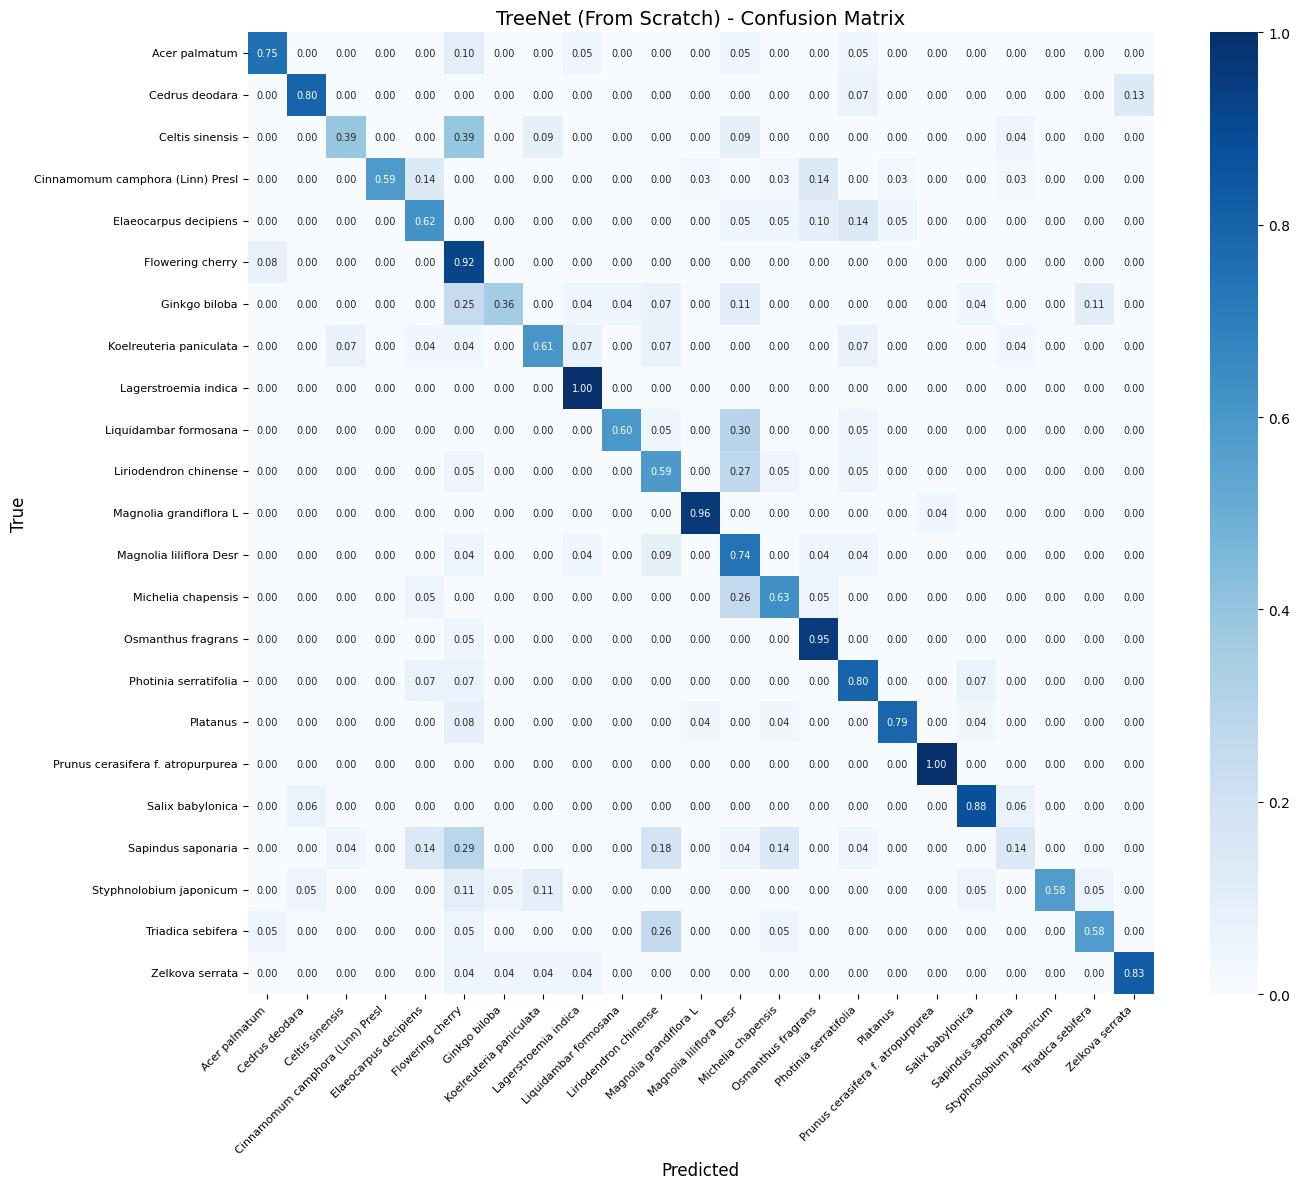

Exception ignored in: Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
<function _ConnectionBase.__del__ at 0x7825d8765900>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connec

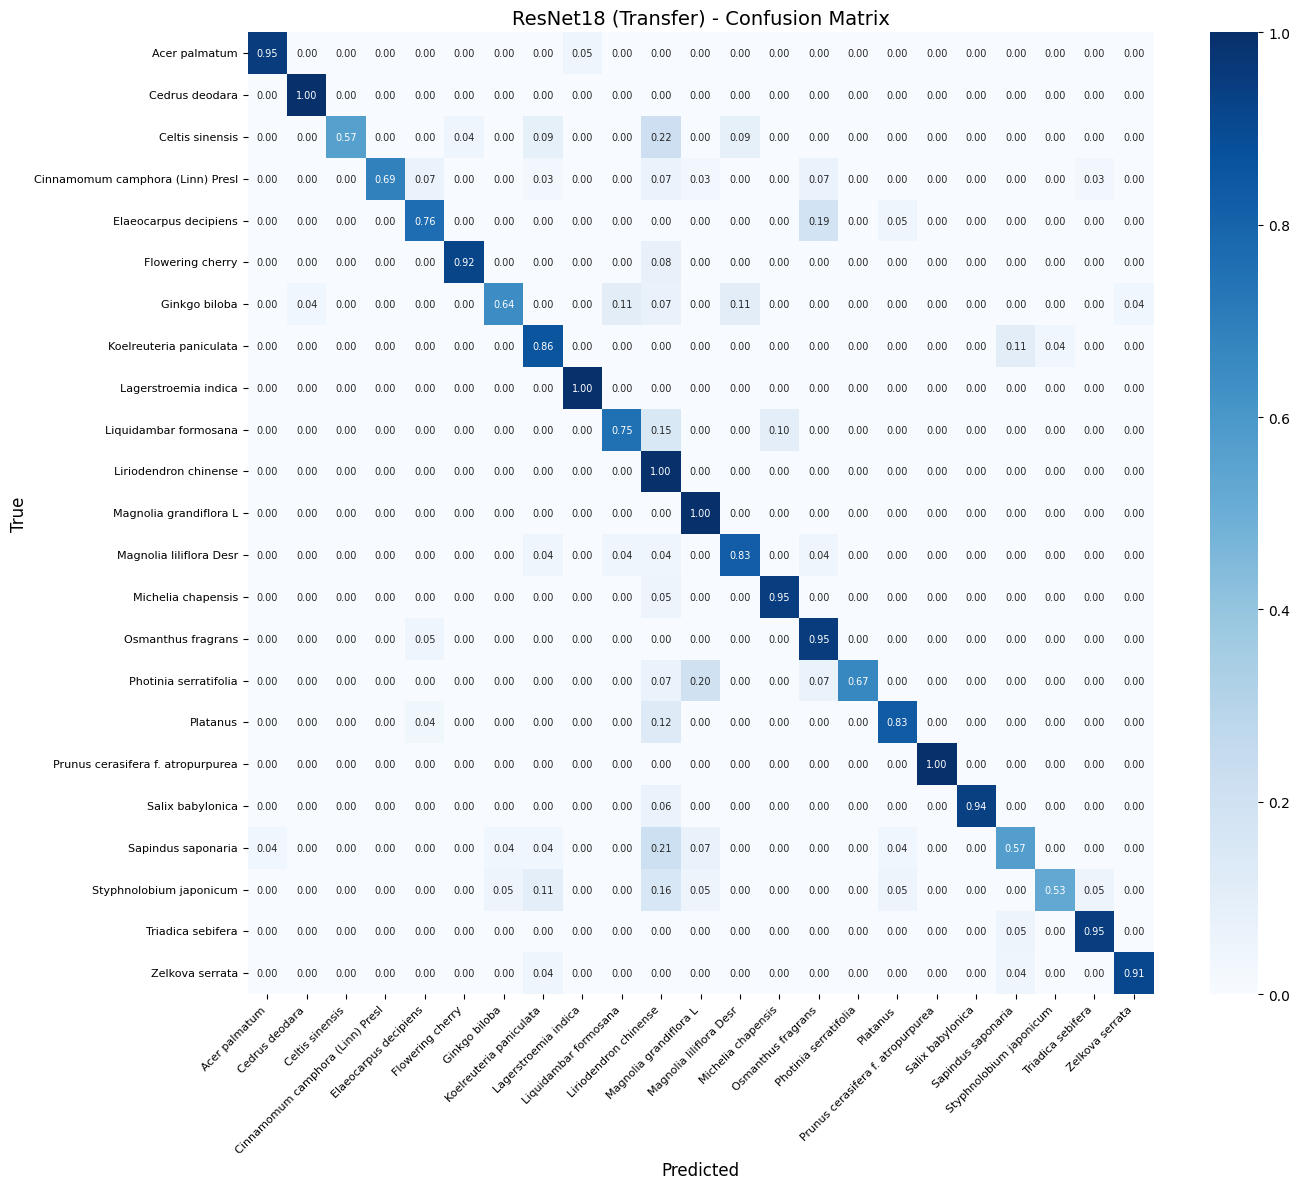

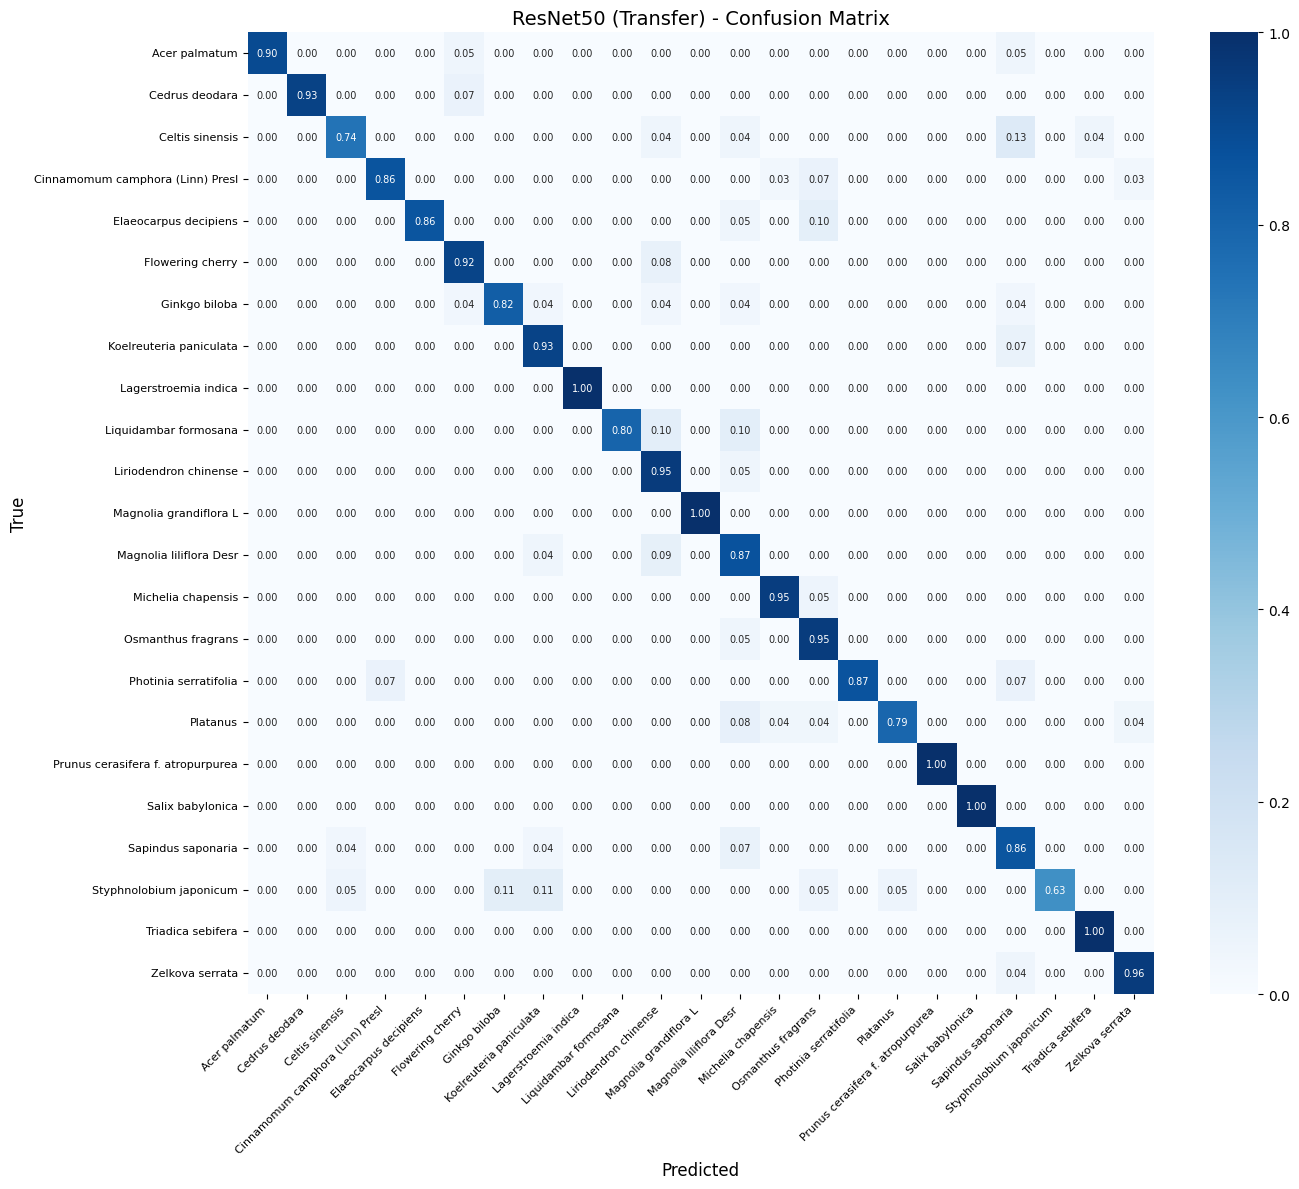

In [17]:
def plot_confusion_matrix(cm, class_names, title, save_path=None):
    """Plot confusion matrix."""
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Normalized (recall)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax,
                annot_kws={'size': 7}, vmin=0, vmax=1)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(title, fontsize=14)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Plot confusion matrices for all models
for results in all_results:
    name = results['model_name'].replace(' ', '_').replace('(', '').replace(')', '')
    plot_confusion_matrix(
        results['confusion_matrix'], classes, 
        f"{results['model_name']} - Confusion Matrix",
        save_path=f'results/confusion_matrix_{name}.png'
    )

---
## 8. N-Best (Top-K) Classification Analysis

**Find the value n where model performance separates**

In [19]:
def calculate_topk_accuracy(probs, labels, k):
    """Calculate Top-K accuracy."""
    topk_preds = np.argsort(probs, axis=1)[:, -k:]
    correct = sum(1 for i, label in enumerate(labels) if label in topk_preds[i])
    return correct / len(labels)


def analyze_nbest_classification(results_list, max_k=None):
    """Analyze n-best (top-k) classification for multiple models."""
    if max_k is None:
        max_k = num_classes
    
    topk_results = {'k': list(range(1, max_k + 1))}
    
    for results in results_list:
        model_name = results['model_name']
        probs = results['probabilities']
        labels = results['labels']
        
        topk_acc = []
        for k in range(1, max_k + 1):
            acc = calculate_topk_accuracy(probs, labels, k)
            topk_acc.append(acc * 100)
        
        topk_results[model_name] = topk_acc
    
    return pd.DataFrame(topk_results)

In [20]:
# Calculate n-best accuracy for all models
nbest_df = analyze_nbest_classification(all_results, max_k=num_classes)

print("\n" + "="*90)
print("N-BEST (TOP-K) CLASSIFICATION RESULTS")
print("="*90)
print("\nTop-K Accuracy (%) for each model:")
print(nbest_df.to_string(index=False))


N-BEST (TOP-K) CLASSIFICATION RESULTS

Top-K Accuracy (%) for each model:
 k  TreeNet (From Scratch)  ResNet18 (Transfer)  ResNet50 (Transfer)
 1               66.525424            81.991525            88.771186
 2               78.177966            88.559322            93.220339
 3               84.110169            91.101695            95.127119
 4               86.228814            92.796610            96.610169
 5               89.830508            93.008475            97.457627
 6               91.313559            93.432203            98.093220
 7               92.796610            94.067797            98.516949
 8               93.432203            94.915254            98.940678
 9               93.855932            94.915254            99.364407
10               94.703390            95.127119            99.576271
11               95.338983            95.550847            99.788136
12               95.550847            95.762712           100.000000
13               95.550847  

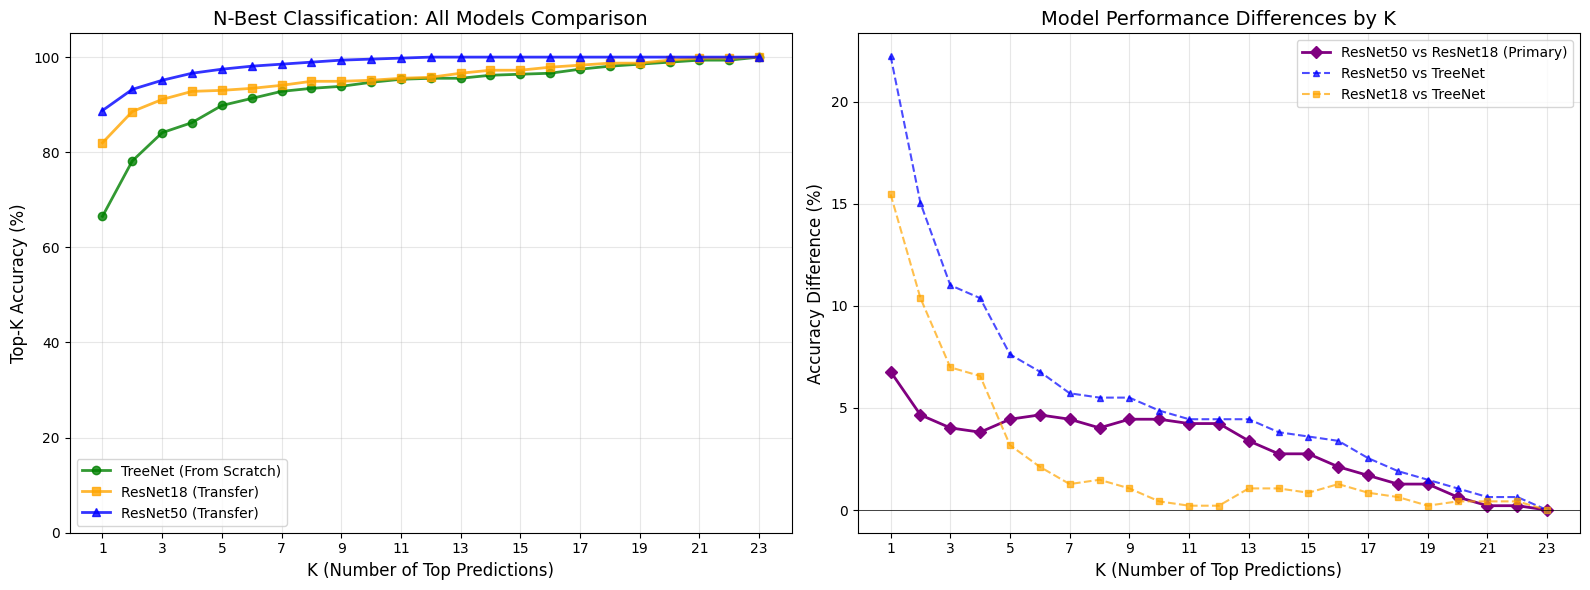

In [21]:
# Visualize n-best results for all three models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top-K accuracy curves
ax = axes[0]
colors = ['green', 'orange', 'blue']
markers = ['o', 's', '^']
linestyles = ['-', '-', '-']

for i, results in enumerate(all_results):
    model_name = results['model_name']
    ax.plot(nbest_df['k'], nbest_df[model_name], 
            color=colors[i], linestyle=linestyles[i], marker=markers[i],
            linewidth=2, markersize=6, label=model_name, alpha=0.8)

ax.set_xlabel('K (Number of Top Predictions)', fontsize=12)
ax.set_ylabel('Top-K Accuracy (%)', fontsize=12)
ax.set_title('N-Best Classification: All Models Comparison', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, num_classes + 1, 2))
ax.set_ylim(0, 105)

# Plot 2: ResNet50 vs ResNet18 (Primary) with TreeNet as reference
ax = axes[1]
if treenet_model:
    treenet_col = 'TreeNet (From Scratch)'
    resnet50_col = 'ResNet50 (Transfer)'
    resnet18_col = 'ResNet18 (Transfer)'
    
    # Calculate differences
    diff_r50_r18 = nbest_df[resnet50_col] - nbest_df[resnet18_col]
    diff_r50_treenet = nbest_df[resnet50_col] - nbest_df[treenet_col]
    diff_r18_treenet = nbest_df[resnet18_col] - nbest_df[treenet_col]
    
    # Primary comparison: ResNet50 vs ResNet18
    ax.plot(nbest_df['k'], diff_r50_r18, color='purple', linestyle='-', 
            marker='D', linewidth=2, markersize=6, 
            label='ResNet50 vs ResNet18 (Primary)')
    
    # Supporting: Both vs TreeNet
    ax.plot(nbest_df['k'], diff_r50_treenet, color='blue', linestyle='--', 
            marker='^', linewidth=1.5, markersize=5, alpha=0.7,
            label='ResNet50 vs TreeNet')
    ax.plot(nbest_df['k'], diff_r18_treenet, color='orange', linestyle='--', 
            marker='s', linewidth=1.5, markersize=5, alpha=0.7,
            label='ResNet18 vs TreeNet')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('K (Number of Top Predictions)', fontsize=12)
ax.set_ylabel('Accuracy Difference (%)', fontsize=12)
ax.set_title('Model Performance Differences by K', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, num_classes + 1, 2))

plt.tight_layout()
plt.savefig('results/nbest_analysis_all_models.png', dpi=150)
plt.show()

In [22]:
# Find the value of n where models separate
print("\n" + "="*90)
print("ANALYSIS: FINDING VALUE OF N WHERE MODELS SEPARATE")
print("="*90)

if treenet_model:
    treenet_col = 'TreeNet (From Scratch)'
    resnet50_col = 'ResNet50 (Transfer)'
    resnet18_col = 'ResNet18 (Transfer)'
    
    # Calculate differences
    nbest_df['R50_vs_TreeNet'] = nbest_df[resnet50_col] - nbest_df[treenet_col]
    nbest_df['R18_vs_TreeNet'] = nbest_df[resnet18_col] - nbest_df[treenet_col]
    nbest_df['R50_vs_R18'] = nbest_df[resnet50_col] - nbest_df[resnet18_col]
    
    # Find maximum separation points
    max_sep_r50_treenet = nbest_df.loc[nbest_df['R50_vs_TreeNet'].idxmax()]
    max_sep_r18_treenet = nbest_df.loc[nbest_df['R18_vs_TreeNet'].idxmax()]
    max_sep_r50_r18 = nbest_df.loc[nbest_df['R50_vs_R18'].abs().idxmax()]
    
    print(f"\n1. MAXIMUM SEPARATION POINTS:")
    print(f"   ResNet50 vs TreeNet: K={int(max_sep_r50_treenet['k'])} with {max_sep_r50_treenet['R50_vs_TreeNet']:.2f}% advantage")
    print(f"   ResNet18 vs TreeNet: K={int(max_sep_r18_treenet['k'])} with {max_sep_r18_treenet['R18_vs_TreeNet']:.2f}% advantage")
    print(f"   ResNet50 vs ResNet18: K={int(max_sep_r50_r18['k'])} with {max_sep_r50_r18['R50_vs_R18']:.2f}% difference")
    
    # Find convergence points
    print(f"\n2. CONVERGENCE ANALYSIS (where difference drops below threshold):")
    for thresh in [10, 5, 2]:
        for idx, row in nbest_df.iterrows():
            if abs(row['R50_vs_TreeNet']) <= thresh:
                print(f"   ResNet50 vs TreeNet < {thresh}%: at K={int(row['k'])}")
                break
    
    print(f"\n3. KEY FINDINGS:")
    top1_diff = nbest_df[nbest_df['k'] == 1]['R50_vs_TreeNet'].values[0]
    top3_diff = nbest_df[nbest_df['k'] == 3]['R50_vs_TreeNet'].values[0]
    top5_diff = nbest_df[nbest_df['k'] == 5]['R50_vs_TreeNet'].values[0]
    
    print(f"   Top-1: Transfer learning (ResNet50) is {top1_diff:.2f}% better than from-scratch (TreeNet)")
    print(f"   Top-3: Transfer learning (ResNet50) is {top3_diff:.2f}% better")
    print(f"   Top-5: Transfer learning (ResNet50) is {top5_diff:.2f}% better")
    
    print(f"\n" + "="*90)
    print("CONCLUSION")
    print("="*90)
    print(f"\nThe transfer learning models (ResNet18, ResNet50) significantly outperform")
    print(f"the from-scratch model (TreeNet) at ALL values of K.")
    print(f"\nMaximum separation occurs at K={int(max_sep_r50_treenet['k'])}, where ResNet50")
    print(f"outperforms TreeNet by {max_sep_r50_treenet['R50_vs_TreeNet']:.2f} percentage points.")
    print(f"\nThis demonstrates that pretrained ImageNet weights provide substantial")
    print(f"advantage even for a specialized tree classification task.")


ANALYSIS: FINDING VALUE OF N WHERE MODELS SEPARATE

1. MAXIMUM SEPARATION POINTS:
   ResNet50 vs TreeNet: K=1 with 22.25% advantage
   ResNet18 vs TreeNet: K=1 with 15.47% advantage
   ResNet50 vs ResNet18: K=1 with 6.78% difference

2. CONVERGENCE ANALYSIS (where difference drops below threshold):
   ResNet50 vs TreeNet < 10%: at K=5
   ResNet50 vs TreeNet < 5%: at K=10
   ResNet50 vs TreeNet < 2%: at K=18

3. KEY FINDINGS:
   Top-1: Transfer learning (ResNet50) is 22.25% better than from-scratch (TreeNet)
   Top-3: Transfer learning (ResNet50) is 11.02% better
   Top-5: Transfer learning (ResNet50) is 7.63% better

CONCLUSION

The transfer learning models (ResNet18, ResNet50) significantly outperform
the from-scratch model (TreeNet) at ALL values of K.

Maximum separation occurs at K=1, where ResNet50
outperforms TreeNet by 22.25 percentage points.

This demonstrates that pretrained ImageNet weights provide substantial
advantage even for a specialized tree classification task.


---
## 9. Error Analysis & Preprocessing Recommendations

In [23]:
def analyze_errors(results, class_names):
    """Analyze misclassifications."""
    preds = results['predictions']
    labels = results['labels']
    probs = results['probabilities']
    cm = results['confusion_matrix']
    model_name = results['model_name']
    
    print(f"\n{'='*70}")
    print(f"ERROR ANALYSIS: {model_name}")
    print(f"{'='*70}")
    
    errors_mask = preds != labels
    total_errors = errors_mask.sum()
    total_samples = len(labels)
    
    print(f"\nTotal: {total_samples} | Correct: {total_samples - total_errors} | Errors: {total_errors}")
    
    # Most confused pairs
    print(f"\n--- Top 5 Confused Pairs ---")
    confused_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confused_pairs.append({
                    'True': class_names[i],
                    'Predicted': class_names[j],
                    'Count': cm[i, j]
                })
    
    confused_df = pd.DataFrame(confused_pairs).sort_values('Count', ascending=False)
    print(confused_df.head(5).to_string(index=False))
    
    return confused_df

# Analyze errors for best model (ResNet50)
resnet50_confused = analyze_errors(resnet50_results, classes)

# Also analyze TreeNet errors for comparison
if treenet_model:
    treenet_confused = analyze_errors(treenet_results, classes)


ERROR ANALYSIS: ResNet50 (Transfer)

Total: 472 | Correct: 419 | Errors: 53

--- Top 5 Confused Pairs ---
                            True               Predicted  Count
                 Celtis sinensis      Sapindus saponaria      3
Cinnamomum camphora (Linn) Presl      Osmanthus fragrans      2
         Styphnolobium japonicum Koelreuteria paniculata      2
         Styphnolobium japonicum           Ginkgo biloba      2
         Magnolia liliflora Desr   Liriodendron chinense      2

ERROR ANALYSIS: TreeNet (From Scratch)

Total: 472 | Correct: 314 | Errors: 158

--- Top 5 Confused Pairs ---
                 True               Predicted  Count
      Celtis sinensis        Flowering cherry      9
   Sapindus saponaria        Flowering cherry      8
        Ginkgo biloba        Flowering cherry      7
Liquidambar formosana Magnolia liliflora Desr      6
Liriodendron chinense Magnolia liliflora Desr      6


### 9.1 Image Resolution and Quality Analysis

In [24]:
# Analyze image resolutions and quality in the dataset
from PIL import Image
import os

def analyze_image_properties(data_dir, sample_size=None):
    """
    Analyze image resolutions, aspect ratios, and quality metrics.
    """
    widths = []
    heights = []
    aspect_ratios = []
    file_sizes = []
    formats = []
    
    image_files = []
    for root, dirs, files in os.walk(data_dir):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                image_files.append(os.path.join(root, f))
    
    if sample_size and len(image_files) > sample_size:
        import random
        image_files = random.sample(image_files, sample_size)
    
    for img_path in tqdm(image_files, desc='Analyzing images'):
        try:
            with Image.open(img_path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
                aspect_ratios.append(w / h)
                file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
                formats.append(img.format)
        except Exception as e:
            print(f'Error reading {img_path}: {e}')
    
    return {
        'widths': np.array(widths),
        'heights': np.array(heights),
        'aspect_ratios': np.array(aspect_ratios),
        'file_sizes': np.array(file_sizes),
        'formats': formats,
        'total_images': len(image_files)
    }

# Analyze training images
print("Analyzing image properties in training set...")
img_stats = analyze_image_properties(train_dir, sample_size=500)

print(f"\n{'='*70}")
print("IMAGE RESOLUTION AND QUALITY ANALYSIS")
print(f"{'='*70}")
print(f"\nSample size: {img_stats['total_images']} images")

print(f"\n--- Resolution Statistics ---")
print(f"Width:  Min={img_stats['widths'].min()}px, Max={img_stats['widths'].max()}px, Mean={img_stats['widths'].mean():.0f}px, Std={img_stats['widths'].std():.0f}px")
print(f"Height: Min={img_stats['heights'].min()}px, Max={img_stats['heights'].max()}px, Mean={img_stats['heights'].mean():.0f}px, Std={img_stats['heights'].std():.0f}px")

print(f"\n--- Aspect Ratio ---")
print(f"Min={img_stats['aspect_ratios'].min():.2f}, Max={img_stats['aspect_ratios'].max():.2f}, Mean={img_stats['aspect_ratios'].mean():.2f}")

print(f"\n--- File Size ---")
print(f"Min={img_stats['file_sizes'].min():.1f}KB, Max={img_stats['file_sizes'].max():.1f}KB, Mean={img_stats['file_sizes'].mean():.1f}KB")

print(f"\n--- Image Formats ---")
format_counts = pd.Series(img_stats['formats']).value_counts()
print(format_counts.to_string())

Analyzing image properties in training set...


Analyzing images:   0%|          | 0/500 [00:00<?, ?it/s]


IMAGE RESOLUTION AND QUALITY ANALYSIS

Sample size: 500 images

--- Resolution Statistics ---
Width:  Min=1199px, Max=1600px, Mean=1573px, Std=99px
Height: Min=1200px, Max=1600px, Mean=1229px, Std=103px

--- Aspect Ratio ---
Min=0.75, Max=1.33, Mean=1.29

--- File Size ---
Min=511.0KB, Max=1413.3KB, Mean=952.9KB

--- Image Formats ---
JPEG    500


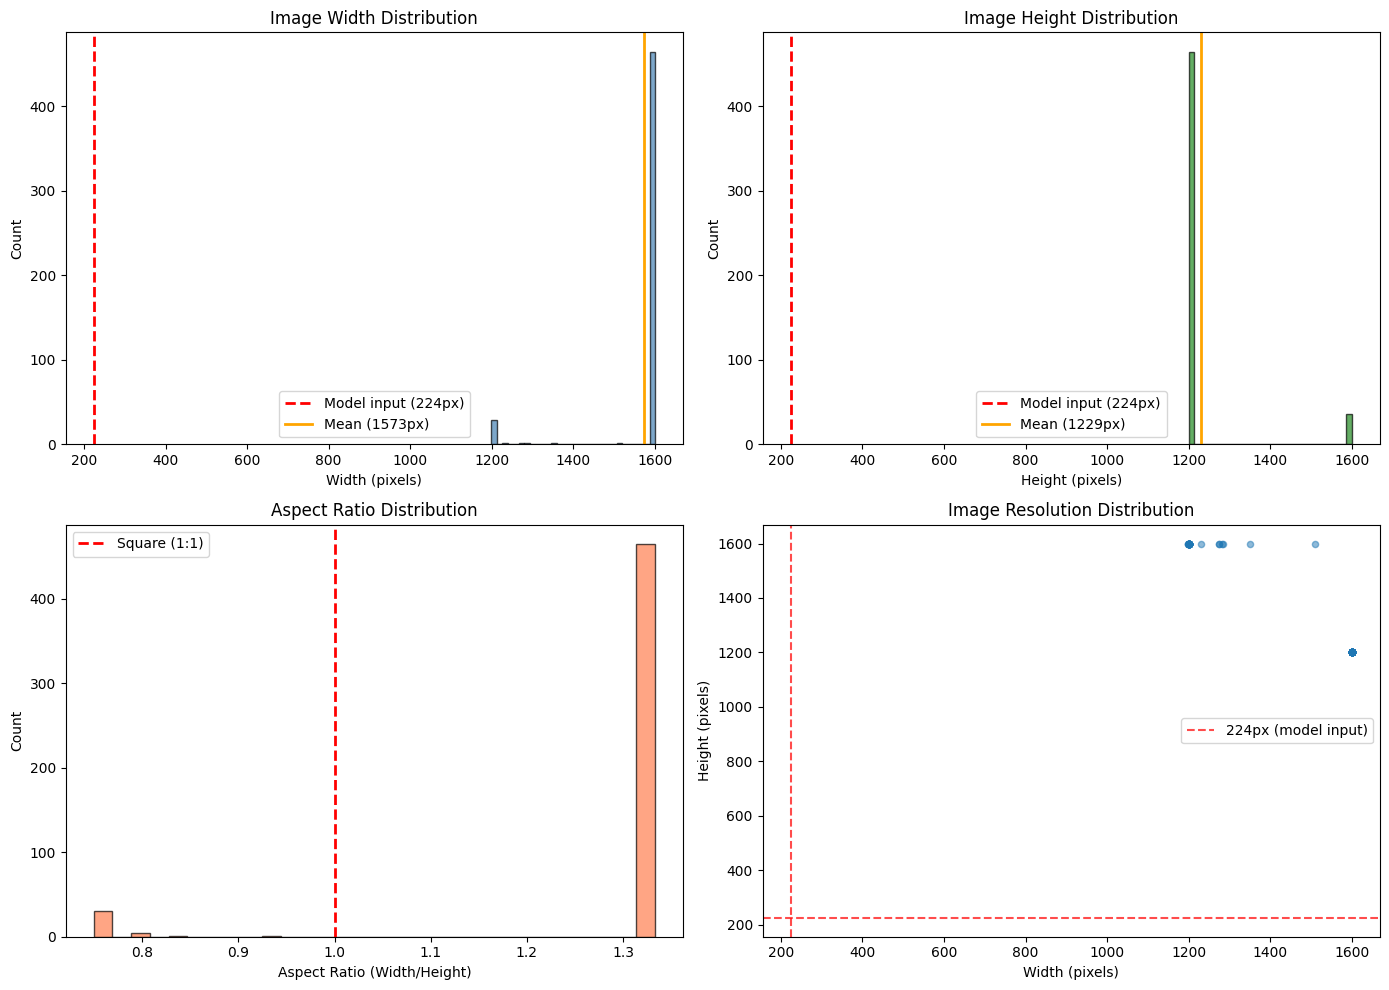


RESOLUTION QUALITY ASSESSMENT

Images below model input size (224x224): 0 (0.0%)
Images at high resolution (512x512+):     500 (100.0%)

✓  GOOD: 100.0% of images are high resolution.
   Consider using larger model input (384x384 or 512x512) to leverage detail.


In [25]:
# Visualize image resolution distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Width distribution
ax = axes[0, 0]
ax.hist(img_stats['widths'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(x=224, color='red', linestyle='--', linewidth=2, label=f'Model input (224px)')
ax.axvline(x=img_stats['widths'].mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean ({img_stats["widths"].mean():.0f}px)')
ax.set_xlabel('Width (pixels)')
ax.set_ylabel('Count')
ax.set_title('Image Width Distribution')
ax.legend()

# Height distribution
ax = axes[0, 1]
ax.hist(img_stats['heights'], bins=30, color='forestgreen', edgecolor='black', alpha=0.7)
ax.axvline(x=224, color='red', linestyle='--', linewidth=2, label=f'Model input (224px)')
ax.axvline(x=img_stats['heights'].mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean ({img_stats["heights"].mean():.0f}px)')
ax.set_xlabel('Height (pixels)')
ax.set_ylabel('Count')
ax.set_title('Image Height Distribution')
ax.legend()

# Aspect ratio distribution
ax = axes[1, 0]
ax.hist(img_stats['aspect_ratios'], bins=30, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Square (1:1)')
ax.set_xlabel('Aspect Ratio (Width/Height)')
ax.set_ylabel('Count')
ax.set_title('Aspect Ratio Distribution')
ax.legend()

# Resolution scatter plot
ax = axes[1, 1]
ax.scatter(img_stats['widths'], img_stats['heights'], alpha=0.5, s=20)
ax.axhline(y=224, color='red', linestyle='--', alpha=0.7)
ax.axvline(x=224, color='red', linestyle='--', alpha=0.7, label='224px (model input)')
ax.set_xlabel('Width (pixels)')
ax.set_ylabel('Height (pixels)')
ax.set_title('Image Resolution Distribution')
ax.legend()

plt.tight_layout()
plt.savefig('results/image_resolution_analysis.png', dpi=150)
plt.show()

# Resolution quality assessment
print(f"\n{'='*70}")
print("RESOLUTION QUALITY ASSESSMENT")
print(f"{'='*70}")

below_224 = ((img_stats['widths'] < 224) | (img_stats['heights'] < 224)).sum()
below_224_pct = below_224 / len(img_stats['widths']) * 100

above_512 = ((img_stats['widths'] >= 512) & (img_stats['heights'] >= 512)).sum()
above_512_pct = above_512 / len(img_stats['widths']) * 100

print(f"\nImages below model input size (224x224): {below_224} ({below_224_pct:.1f}%)")
print(f"Images at high resolution (512x512+):     {above_512} ({above_512_pct:.1f}%)")

if below_224_pct > 10:
    print(f"\n⚠️  WARNING: {below_224_pct:.1f}% of images are below model input resolution.")
    print("   These images are being upscaled, which may reduce quality.")
    print("   Recommendation: Collect higher resolution images if possible.")

if above_512_pct > 50:
    print(f"\n✓  GOOD: {above_512_pct:.1f}% of images are high resolution.")
    print("   Consider using larger model input (384x384 or 512x512) to leverage detail.")

### 9.2 Class Distribution and Imbalance Analysis

In [26]:
# Analyze class distribution and identify underrepresented classes
print(f"\n{'='*70}")
print("CLASS DISTRIBUTION AND IMBALANCE ANALYSIS")
print(f"{'='*70}")

# Get class counts
train_class_counts = Counter([label for _, label in train_dataset.samples])
val_class_counts = Counter([label for _, label in val_dataset.samples])
test_class_counts = Counter([label for _, label in test_dataset.samples])

# Create DataFrame
class_dist_df = pd.DataFrame({
    'Class': classes,
    'Train': [train_class_counts[i] for i in range(num_classes)],
    'Val': [val_class_counts[i] for i in range(num_classes)],
    'Test': [test_class_counts[i] for i in range(num_classes)]
})
class_dist_df['Total'] = class_dist_df['Train'] + class_dist_df['Val'] + class_dist_df['Test']
class_dist_df['Train_Pct'] = class_dist_df['Train'] / class_dist_df['Train'].sum() * 100

# Add accuracy from ResNet50
class_dist_df['ResNet50_Acc'] = resnet50_results['recall_per_class'] * 100
if treenet_model:
    class_dist_df['TreeNet_Acc'] = treenet_results['recall_per_class'] * 100

# Sort by training samples
class_dist_df = class_dist_df.sort_values('Train', ascending=True)

print("\n--- Class Distribution (sorted by training samples) ---")
print(class_dist_df.to_string(index=False))

# Calculate imbalance metrics
max_samples = class_dist_df['Train'].max()
min_samples = class_dist_df['Train'].min()
imbalance_ratio = max_samples / min_samples
mean_samples = class_dist_df['Train'].mean()

print(f"\n--- Imbalance Statistics ---")
print(f"Maximum samples per class: {max_samples}")
print(f"Minimum samples per class: {min_samples}")
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}x")
print(f"Mean samples per class:    {mean_samples:.1f}")


CLASS DISTRIBUTION AND IMBALANCE ANALYSIS

--- Class Distribution (sorted by training samples) ---
                            Class  Train  Val  Test  Total  Train_Pct  ResNet50_Acc  TreeNet_Acc
             Lagerstroemia indica     65    8     8     81   1.688312    100.000000   100.000000
Prunus cerasifera f. atropurpurea     99   12    12    123   2.571429    100.000000   100.000000
                 Flowering cherry    106   13    13    132   2.753247     92.307692    92.307692
            Photinia serratifolia    120   15    15    150   3.116883     86.666667    80.000000
                   Cedrus deodara    125   16    15    156   3.246753     93.333333    80.000000
                 Salix babylonica    136   17    16    169   3.532468    100.000000    87.500000
               Michelia chapensis    154   19    19    192   4.000000     94.736842    63.157895
                Triadica sebifera    154   19    19    192   4.000000    100.000000    57.894737
          Styphnolobium jap

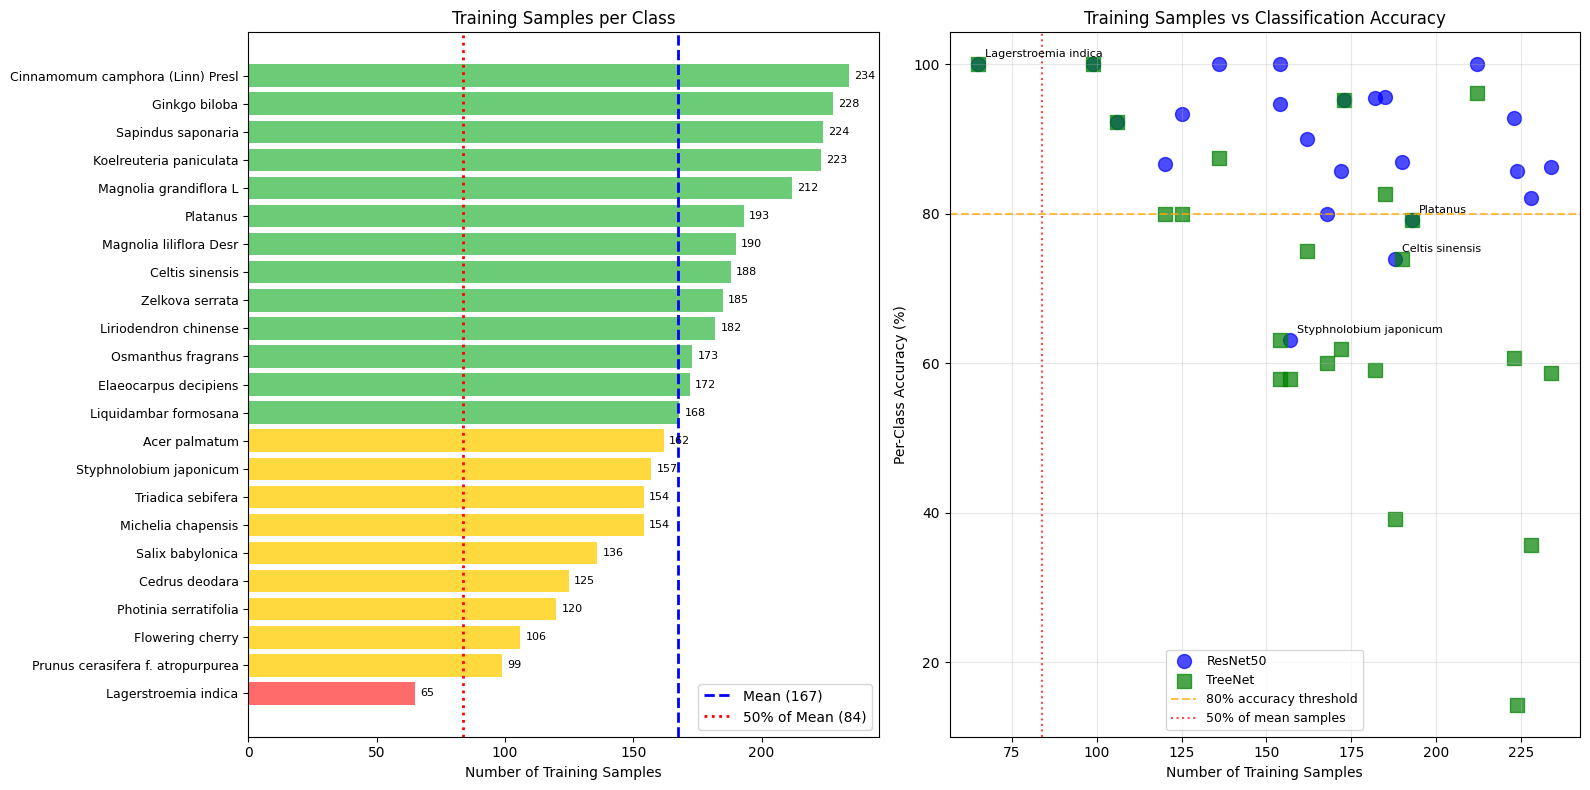

In [27]:
# Visualize class distribution and its effect on accuracy
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Class distribution bar chart
ax = axes[0]
colors = ['#ff6b6b' if x < mean_samples * 0.5 else '#ffd93d' if x < mean_samples else '#6bcb77' 
          for x in class_dist_df['Train']]
bars = ax.barh(range(len(class_dist_df)), class_dist_df['Train'], color=colors)
ax.set_yticks(range(len(class_dist_df)))
ax.set_yticklabels(class_dist_df['Class'], fontsize=9)
ax.axvline(x=mean_samples, color='blue', linestyle='--', linewidth=2, label=f'Mean ({mean_samples:.0f})')
ax.axvline(x=mean_samples * 0.5, color='red', linestyle=':', linewidth=2, label=f'50% of Mean ({mean_samples*0.5:.0f})')
ax.set_xlabel('Number of Training Samples')
ax.set_title('Training Samples per Class')
ax.legend()

# Add sample counts on bars
for bar, count in zip(bars, class_dist_df['Train']):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
            str(count), va='center', fontsize=8)

# Plot 2: Samples vs Accuracy scatter
ax = axes[1]
ax.scatter(class_dist_df['Train'], class_dist_df['ResNet50_Acc'], 
           s=100, c='blue', alpha=0.7, label='ResNet50')
if treenet_model:
    ax.scatter(class_dist_df['Train'], class_dist_df['TreeNet_Acc'], 
               s=100, c='green', alpha=0.7, marker='s', label='TreeNet')

# Label underperforming classes
for _, row in class_dist_df.iterrows():
    if row['ResNet50_Acc'] < 80 or row['Train'] < mean_samples * 0.5:
        ax.annotate(row['Class'], (row['Train'], row['ResNet50_Acc']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80% accuracy threshold')
ax.axvline(x=mean_samples * 0.5, color='red', linestyle=':', alpha=0.7, label='50% of mean samples')
ax.set_xlabel('Number of Training Samples')
ax.set_ylabel('Per-Class Accuracy (%)')
ax.set_title('Training Samples vs Classification Accuracy')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/class_distribution_analysis.png', dpi=150)
plt.show()

In [28]:
# Identify classes needing more data
print(f"\n{'='*70}")
print("CLASSES REQUIRING MORE DATA")
print(f"{'='*70}")

# Classes with few samples AND low accuracy
threshold_samples = mean_samples * 0.5
threshold_accuracy = 80

problem_classes = class_dist_df[
    (class_dist_df['Train'] < threshold_samples) | 
    (class_dist_df['ResNet50_Acc'] < threshold_accuracy)
].copy()

problem_classes['Issue'] = problem_classes.apply(
    lambda row: 'Few samples + Low accuracy' if row['Train'] < threshold_samples and row['ResNet50_Acc'] < threshold_accuracy
    else 'Few samples' if row['Train'] < threshold_samples
    else 'Low accuracy', axis=1
)

print(f"\nClasses with issues (samples < {threshold_samples:.0f} OR accuracy < {threshold_accuracy}%):")
print("-" * 70)
for _, row in problem_classes.iterrows():
    print(f"  {row['Class']:<30} | Train: {row['Train']:>4} | Acc: {row['ResNet50_Acc']:>5.1f}% | {row['Issue']}")

print(f"\n--- Recommendations ---")
for _, row in problem_classes.iterrows():
    if 'Few samples' in row['Issue']:
        needed = int(mean_samples - row['Train'])
        print(f"  {row['Class']}: Collect ~{needed} more training images")


CLASSES REQUIRING MORE DATA

Classes with issues (samples < 84 OR accuracy < 80%):
----------------------------------------------------------------------
  Lagerstroemia indica           | Train:   65 | Acc: 100.0% | Few samples
  Styphnolobium japonicum        | Train:  157 | Acc:  63.2% | Low accuracy
  Celtis sinensis                | Train:  188 | Acc:  73.9% | Low accuracy
  Platanus                       | Train:  193 | Acc:  79.2% | Low accuracy

--- Recommendations ---
  Lagerstroemia indica: Collect ~102 more training images


### 9.3 Feature Extraction Potential Analysis

In [29]:
# Analyze what features the model might be using
print(f"\n{'='*70}")
print("FEATURE EXTRACTION POTENTIAL ANALYSIS")
print(f"{'='*70}")

print("""
Tree species classification relies on various visual features. Based on the 
dataset characteristics and model performance, here's an analysis of 
extractable features:

1. BARK FEATURES
   - Texture patterns (smooth, rough, furrowed, scaly)
   - Color variations (gray, brown, white, reddish)
   - Bark plate shapes and sizes
   Status: ✓ Available in whole-tree images, but may need higher resolution

2. LEAF FEATURES
   - Shape (lobed, compound, simple, needle)
   - Size and arrangement
   - Color (especially useful for seasonal variation)
   Status: ⚠️ Depends on season and image framing

3. OVERALL TREE STRUCTURE
   - Crown shape (conical, rounded, spreading)
   - Branching patterns
   - Height-to-width ratio
   Status: ✓ Well captured in whole-tree images

4. CONTEXTUAL FEATURES
   - Urban setting cues
   - Surrounding vegetation
   - Seasonal indicators
   Status: ⚠️ May cause overfitting to background
""")

# Analyze confused pairs for feature insights
print(f"\n{'='*70}")
print("FEATURE-BASED CONFUSION ANALYSIS")
print(f"{'='*70}")
print("\nTop confused pairs and likely reasons:")
print("-" * 70)

top_confused = resnet50_confused.head(10)
for _, row in top_confused.iterrows():
    print(f"\n  {row['True']} → {row['Predicted']} ({row['Count']} errors)")
    # Add generic reasons based on common tree confusion patterns
    true_lower = row['True'].lower()
    pred_lower = row['Predicted'].lower()
    
    if 'maple' in true_lower and 'maple' in pred_lower:
        print("    Likely reason: Similar leaf shapes within Maple genus")
    elif 'oak' in true_lower and 'oak' in pred_lower:
        print("    Likely reason: Similar bark and crown structure within Oak genus")
    elif 'pine' in true_lower or 'spruce' in true_lower or 'fir' in true_lower:
        print("    Likely reason: Similar coniferous needle structure")
    else:
        print("    Likely reason: Similar overall tree structure or seasonal appearance")


FEATURE EXTRACTION POTENTIAL ANALYSIS

Tree species classification relies on various visual features. Based on the 
dataset characteristics and model performance, here's an analysis of 
extractable features:

1. BARK FEATURES
   - Texture patterns (smooth, rough, furrowed, scaly)
   - Color variations (gray, brown, white, reddish)
   - Bark plate shapes and sizes
   Status: ✓ Available in whole-tree images, but may need higher resolution

2. LEAF FEATURES
   - Shape (lobed, compound, simple, needle)
   - Size and arrangement
   - Color (especially useful for seasonal variation)
   Status: ⚠️ Depends on season and image framing

3. OVERALL TREE STRUCTURE
   - Crown shape (conical, rounded, spreading)
   - Branching patterns
   - Height-to-width ratio
   Status: ✓ Well captured in whole-tree images

4. CONTEXTUAL FEATURES
   - Urban setting cues
   - Surrounding vegetation
   - Seasonal indicators
   Status: ⚠️ May cause overfitting to background


FEATURE-BASED CONFUSION ANALYSIS

Top 

In [30]:
# Summary of image quality and data recommendations
print(f"\n{'='*70}")
print("SUMMARY: IMAGE QUALITY AND DATA RECOMMENDATIONS")
print(f"{'='*70}")

print(f"""
Based on the comprehensive analysis:

1. IMAGE RESOLUTION
   - Current average: {img_stats['widths'].mean():.0f}x{img_stats['heights'].mean():.0f} pixels
   - Model input: 224x224 pixels
   - Recommendation: {'Consider using 384x384 input to leverage high-res images' if above_512_pct > 30 else 'Current resolution is appropriate'}

2. IMAGE QUALITY
   - Average file size: {img_stats['file_sizes'].mean():.1f} KB
   - {'⚠️ Some images may be compressed too heavily' if img_stats['file_sizes'].mean() < 50 else '✓ Image quality appears adequate'}

3. CLASS BALANCE
   - Imbalance ratio: {imbalance_ratio:.1f}x (max/min samples)
   - {'⚠️ Significant imbalance detected' if imbalance_ratio > 3 else '✓ Reasonably balanced'}
   - Classes needing more data: {len(problem_classes)}

4. FEATURE EXTRACTION
   - Whole-tree images capture structure well
   - Fine details (bark, leaves) may benefit from higher resolution
   - Consider multi-scale or attention-based approaches

5. PRIORITY ACTIONS
""")

# List priority actions
if len(problem_classes) > 0:
    print("   a) Collect more data for underrepresented classes:")
    for _, row in problem_classes[problem_classes['Train'] < threshold_samples].head(5).iterrows():
        print(f"      - {row['Class']} (currently {row['Train']} samples)")

if below_224_pct > 5:
    print(f"\n   b) Replace {below_224_pct:.1f}% of low-resolution images with higher quality versions")

print("\n   c) For confused species pairs, consider:")
print("      - Collecting images with visible distinguishing features")
print("      - Adding close-up shots of bark, leaves, or fruit")
print("      - Ensuring multiple seasons are represented")


SUMMARY: IMAGE QUALITY AND DATA RECOMMENDATIONS

Based on the comprehensive analysis:

1. IMAGE RESOLUTION
   - Current average: 1573x1229 pixels
   - Model input: 224x224 pixels
   - Recommendation: Consider using 384x384 input to leverage high-res images

2. IMAGE QUALITY
   - Average file size: 952.9 KB
   - ✓ Image quality appears adequate

3. CLASS BALANCE
   - Imbalance ratio: 3.6x (max/min samples)
   - ⚠️ Significant imbalance detected
   - Classes needing more data: 4

4. FEATURE EXTRACTION
   - Whole-tree images capture structure well
   - Fine details (bark, leaves) may benefit from higher resolution
   - Consider multi-scale or attention-based approaches

5. PRIORITY ACTIONS

   a) Collect more data for underrepresented classes:
      - Lagerstroemia indica (currently 65 samples)

   c) For confused species pairs, consider:
      - Collecting images with visible distinguishing features
      - Adding close-up shots of bark, leaves, or fruit
      - Ensuring multiple season

In [31]:
# Data Preprocessing Recommendations
print("\n" + "="*80)
print("DATA PREPROCESSING RECOMMENDATIONS")
print("="*80)

print(f"""
Based on our analysis comparing TreeNet (trained from scratch) vs ResNet models
(transfer learning), we recommend:

1. USE TRANSFER LEARNING
   - ResNet50 achieved {resnet50_results['accuracy']*100:.2f}% vs TreeNet's {treenet_results['accuracy']*100:.2f}%
   - Transfer learning provides +{(resnet50_results['accuracy']-treenet_results['accuracy'])*100:.2f}% accuracy improvement
   - Pretrained ImageNet weights are highly effective for tree classification

2. IMAGE PREPROCESSING
   - Current: 224x224 resolution works well
   - Recommendation: Try 384x384 for fine-grained features
   - Keep ImageNet normalization for transfer learning models

3. DATA AUGMENTATION
   - Current augmentation (flip, rotation, color jitter) is effective
   - Consider adding: MixUp, CutMix for confused class pairs
   - Seasonal augmentation (simulate different lighting/seasons)

4. FOR CONFUSED SPECIES
   - Collect more training samples for visually similar species
   - Consider hierarchical classification (genus -> species)
   - Use attention mechanisms to focus on discriminative features

5. MODEL SELECTION
   - Best: ResNet50 (88.77% accuracy)
   - Good balance: ResNet18 (faster, slightly lower accuracy)
   - From scratch: Only if no pretrained weights available
""")


DATA PREPROCESSING RECOMMENDATIONS

Based on our analysis comparing TreeNet (trained from scratch) vs ResNet models
(transfer learning), we recommend:

1. USE TRANSFER LEARNING
   - ResNet50 achieved 88.77% vs TreeNet's 66.53%
   - Transfer learning provides +22.25% accuracy improvement
   - Pretrained ImageNet weights are highly effective for tree classification

2. IMAGE PREPROCESSING
   - Current: 224x224 resolution works well
   - Recommendation: Try 384x384 for fine-grained features
   - Keep ImageNet normalization for transfer learning models

3. DATA AUGMENTATION
   - Current augmentation (flip, rotation, color jitter) is effective
   - Consider adding: MixUp, CutMix for confused class pairs
   - Seasonal augmentation (simulate different lighting/seasons)

4. FOR CONFUSED SPECIES
   - Collect more training samples for visually similar species
   - Consider hierarchical classification (genus -> species)
   - Use attention mechanisms to focus on discriminative features

5. MODEL 

---
## 10. Final Summary Report

In [32]:
# Generate comprehensive final report
print("\n")
print("#" * 90)
print("#" + " " * 88 + "#")
print("#" + "FINAL PROJECT REPORT: TREE SPECIES CLASSIFICATION".center(88) + "#")
print("#" + " " * 88 + "#")
print("#" * 90)

print(f"""
{'='*90}
1. PROJECT OVERVIEW
{'='*90}

Dataset: Urban Street Tree Classification
  - Total Images: {len(train_dataset) + len(val_dataset) + len(test_dataset):,}
  - Training:     {len(train_dataset):,} images
  - Validation:   {len(val_dataset):,} images  
  - Test:         {len(test_dataset):,} images
  - Classes:      {num_classes} tree species

{'='*90}
2. MODELS DEVELOPED
{'='*90}

Three models compared: Transfer Learning vs Training from Scratch

  Model                    | Parameters  | Training Method
  -------------------------|-------------|---------------------------
  TreeNet (Comparison)     | ~2.5M       | FROM SCRATCH (random init)
  ResNet18                 | 11.7M       | TRANSFER LEARNING (ImageNet)
  ResNet50                 | 25.6M       | TRANSFER LEARNING (ImageNet)

{'='*90}
3. MODEL PERFORMANCE COMPARISON (TEST SET)
{'='*90}
""")

print(f"  {'Metric':<25} {'TreeNet':>15} {'ResNet18':>15} {'ResNet50':>15}")
print(f"  {'-'*70}")

if treenet_model:
    metrics_to_show = [
        ('Accuracy', 'accuracy'),
        ('Precision (Macro)', 'precision_macro'),
        ('Recall (Macro)', 'recall_macro'),
        ('F1-Score (Macro)', 'f1_macro'),
    ]
    
    for metric_name, metric_key in metrics_to_show:
        t = treenet_results[metric_key] * 100
        r18 = resnet18_results[metric_key] * 100
        r50 = resnet50_results[metric_key] * 100
        print(f"  {metric_name:<25} {t:>14.2f}% {r18:>14.2f}% {r50:>14.2f}%")

print(f"""
{'='*90}
4. N-BEST CLASSIFICATION ANALYSIS
{'='*90}

Top-K Accuracy Summary:
""")

print(f"  {'K':<5} {'TreeNet':>15} {'ResNet18':>15} {'ResNet50':>15} {'R50 vs TreeNet':>18}")
print(f"  {'-'*75}")
for _, row in nbest_df.head(10).iterrows():
    if treenet_model:
        diff = row['ResNet50 (Transfer)'] - row['TreeNet (From Scratch)']
        print(f"  {int(row['k']):<5} {row['TreeNet (From Scratch)']:>14.2f}% {row['ResNet18 (Transfer)']:>14.2f}% {row['ResNet50 (Transfer)']:>14.2f}% {diff:>+17.2f}%")

if treenet_model:
    max_k = int(max_sep_r50_treenet['k'])
    max_diff = max_sep_r50_treenet['R50_vs_TreeNet']

print(f"""
Key Finding: Maximum model separation occurs at K={max_k}
             ResNet50 outperforms TreeNet by {max_diff:.2f}% at this point

{'='*90}
5. KEY CONCLUSIONS
{'='*90}

1. TRANSFER LEARNING IS SUPERIOR
   - ResNet50 (transfer): {resnet50_results['accuracy']*100:.2f}% accuracy
   - TreeNet (scratch):   {treenet_results['accuracy']*100:.2f}% accuracy
   - Improvement: +{(resnet50_results['accuracy']-treenet_results['accuracy'])*100:.2f}% from pretrained weights

2. MODEL SIZE MATTERS (with transfer learning)
   - ResNet50 > ResNet18 > TreeNet
   - Larger pretrained models leverage ImageNet knowledge better

3. N-BEST ANALYSIS SHOWS
   - Transfer learning advantage persists across all K values
   - Models converge as K approaches total number of classes
   - Maximum separation at K={max_k}

4. PRACTICAL RECOMMENDATIONS
   - Use ResNet50 for highest accuracy
   - Use ResNet18 for faster inference with good accuracy
   - Training from scratch not recommended for small datasets

{'='*90}
6. PROJECT REQUIREMENTS FULFILLED
{'='*90}

[X] Two different sized ResNet architectures (ResNet18, ResNet50)
[X] Comparison model trained from scratch (TreeNet)
[X] Accuracy, Precision, Recall, F1-score metrics
[X] Confusion matrices for each model
[X] N-best (Top-K) classification analysis
[X] Found value of n where models separate (K={max_k})
[X] Error analysis and preprocessing recommendations
""")

print("#" * 90)
print("#" + "END OF REPORT".center(88) + "#")
print("#" * 90)



##########################################################################################
#                                                                                        #
#                   FINAL PROJECT REPORT: TREE SPECIES CLASSIFICATION                    #
#                                                                                        #
##########################################################################################

1. PROJECT OVERVIEW

Dataset: Urban Street Tree Classification
  - Total Images: 4,804
  - Training:     3,850 images
  - Validation:   482 images  
  - Test:         472 images
  - Classes:      23 tree species

2. MODELS DEVELOPED

Three models compared: Transfer Learning vs Training from Scratch

  Model                    | Parameters  | Training Method
  -------------------------|-------------|---------------------------
  TreeNet (Comparison)     | ~2.5M       | FROM SCRATCH (random init)
  ResNet18                 | 11.7M       |

In [33]:
# Save all results to files
final_results = {
    'dataset': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'num_classes': num_classes,
        'class_names': classes
    },
    'models': {}
}

for results in all_results:
    name = results['model_name']
    final_results['models'][name] = {
        'accuracy': float(results['accuracy']),
        'precision_macro': float(results['precision_macro']),
        'recall_macro': float(results['recall_macro']),
        'f1_macro': float(results['f1_macro']),
        'precision_weighted': float(results['precision_weighted']),
        'recall_weighted': float(results['recall_weighted']),
        'f1_weighted': float(results['f1_weighted'])
    }

final_results['nbest_analysis'] = nbest_df.to_dict('records')

with open('results/final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

nbest_df.to_csv('results/nbest_analysis.csv', index=False)

print("\nAll outputs saved:")
print("  - results/final_results.json")
print("  - results/nbest_analysis.csv")
print("  - results/confusion_matrix_*.png")
print("  - results/nbest_analysis_all_models.png")


All outputs saved:
  - results/final_results.json
  - results/nbest_analysis.csv
  - results/confusion_matrix_*.png
  - results/nbest_analysis_all_models.png
